# Classification models

We can now create a classification model.

As always, we will start by importing the necessary libraries and loading the data.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    PowerTransformer,
    StandardScaler,
)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.dummy import DummyClassifier

# linear models
from sklearn.linear_model import LogisticRegression

# tree models
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# svm
from sklearn.svm import SVC

# kNN
from sklearn.neighbors import KNeighborsClassifier

from fraud.config import PROCESSED_DATA_FILE
from fraud.plots import (
    plot_model_performance_metrics,
)
from fraud.models import RANDOM_STATE
from fraud.models import (
    build_classification_model_pipeline,
    train_and_validate_classification_model,
    summarize_model_performance,
)

In [2]:
df = pd.read_parquet(PROCESSED_DATA_FILE, engine="fastparquet")

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262594 entries, 0 to 262593
Data columns (total 28 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    262594 non-null  float64
 1   V1      262594 non-null  float64
 2   V2      262594 non-null  float64
 3   V3      262594 non-null  float64
 4   V4      262594 non-null  float64
 5   V5      262594 non-null  float64
 6   V6      262594 non-null  float64
 7   V7      262594 non-null  float64
 8   V8      262594 non-null  float64
 9   V9      262594 non-null  float64
 10  V10     262594 non-null  float64
 11  V11     262594 non-null  float64
 12  V12     262594 non-null  float64
 13  V14     262594 non-null  float64
 14  V16     262594 non-null  float64
 15  V17     262594 non-null  float64
 16  V18     262594 non-null  float64
 17  V19     262594 non-null  float64
 18  V20     262594 non-null  float64
 19  V21     262594 non-null  float64
 20  V23     262594 non-null  float64
 21  V24     26

## Preprocessing setup

Prior to building the model, we need to preprocess the data. We will start by defining the target variable and the features:

In [4]:
X = df.drop(columns=["Class"])
y = df["Class"]

le = LabelEncoder()
y = le.fit_transform(y.values.ravel())

X.shape, y.shape

((262594, 27), (262594,))

In [5]:
le.classes_

array([0, 1], dtype=int8)

In [6]:
y[:5]

array([0, 0, 0, 0, 0])

We have seen that features like `Amount` have a high skewness. We will apply a power transformation. To the other features, we will apply a robust scaler since they have outliers.

In [7]:
columns_power_transform = ["Time", "Amount"]
target = ["Class"]

columns_robust_scaler = [
    column for column in X.columns if column not in columns_power_transform
]

columns_robust_scaler

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28']

Since the exploration of the data has shown that the target column is imbalanced, we will use the stratified split to keep the same distribution of classes in the train and test sets. This will be achieved by using the `StratifiedKFold` class from the sklearn library.

The `StratifiedKFold` class will split the data into `n_splits` folds, keeping the same distribution of classes in each fold. This allows us to train the model on different subsets of the data and evaluate its performance on the test set.


In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

The SciKit-Learn library provides a `ColumnTransformer` class that allows us to apply different transformations to different columns of the data. We will use this class to apply the transformations to the data.

We will first test a handful of models to see which one performs best. Then, we will fine-tune the hyperparameters of the best model to improve its performance.

Some models are tree-based models, which do not require scaling of the numerical features. While the other models require scaling. So we are going to define a variable to non-tree-based models.


In [9]:
preprocessing_not_tree = ColumnTransformer(
    transformers=[
        ("power_transform", PowerTransformer(), columns_power_transform),
        ("robust_scaler", StandardScaler(), columns_robust_scaler),
    ],
    remainder="passthrough",
)

As remembered before, we have an imbalanced target column. Most classification models have a parameter called `class_weight` that allows us to give more importance to the minority class. We will use this parameter, when available, to make the models give more importance to the conversion class.

One of our models, the LGMBClassifier, has a parameter called `scale_pos_weight` that allows us to give more importance to the minority class. We will use this parameter to make the model give more importance to the conversion class. The value of this parameter is calculated as the ratio of the number of samples in the majority class to the number of samples in the minority class:


In [10]:
class_weight_proportion = compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weight_ratio = class_weight_proportion[1] / class_weight_proportion[0]
class_weight_ratio

np.float64(532.7276422764228)

## Evaluating some classification models

Let's define our classifiers. For comparison, a baseline model, `DummyClassifier`, will be defined as well. The baseline model will make predictions based on the stratified strategy, which predicts the most frequent class in the training set:

In [11]:
classifiers = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessing_not_tree,
        "classifier": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classifier": DecisionTreeClassifier(class_weight="balanced"),
    },
    "LGBMClassifier": {
        "preprocessor": None,
        "classifier": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=class_weight_ratio,
        ),
    },
    # "SVC": {
    #     "preprocessor": preprocessing_not_tree,
    #     "classifier": SVC(class_weight="balanced"),
    # },
    "KNeighborsClassifier": {
        "preprocessor": preprocessing_not_tree,
        "classifier": KNeighborsClassifier(n_jobs=-1),
    },
}

Some useful functions were defined to help us evaluate the models and summarize the results:

In [12]:
results = {
    model_name: train_and_validate_classification_model(X, y, kf, **classifier)
    for model_name, classifier in classifiers.items()
}

df_results = summarize_model_performance(results)

df_results

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_neg_brier_score,test_f1_weighted,time_seconds
0,DummyClassifier,0.274833,0.029349,0.996211,0.499037,0.0,0.0,0.0,0.498941,0.001866,-0.00398,0.996239,0.304182
1,DummyClassifier,0.089341,0.025969,0.996458,0.499161,0.0,0.0,0.0,0.498903,0.001866,-0.004056,0.996363,0.11531
2,DummyClassifier,0.064981,0.030601,0.996268,0.504116,0.010101,0.010101,0.010101,0.499075,0.001885,-0.003732,0.996268,0.095582
3,DummyClassifier,0.082514,0.026308,0.996211,0.499046,0.0,0.0,0.0,0.499046,0.001885,-0.003789,0.99622,0.108821
4,DummyClassifier,0.137137,0.031739,0.996173,0.50411,0.009852,0.009524,0.010204,0.49917,0.001866,-0.003523,0.996239,0.168877
5,LogisticRegression,2.275345,0.161725,0.976523,0.937314,0.124911,0.067124,0.897959,0.963284,0.887383,-0.021263,0.986491,2.437069
6,LogisticRegression,2.189333,0.136402,0.978027,0.953345,0.136228,0.073506,0.928571,0.979766,0.878783,-0.020202,0.987281,2.325735
7,LogisticRegression,2.628426,0.151144,0.977437,0.943328,0.131868,0.07109,0.909091,0.987853,0.878284,-0.02005,0.986955,2.779569
8,LogisticRegression,2.475886,0.148401,0.978827,0.954107,0.141975,0.076859,0.929293,0.983221,0.851028,-0.019931,0.987684,2.624287
9,LogisticRegression,2.612381,0.146105,0.97418,0.956511,0.119481,0.0638,0.938776,0.981682,0.902687,-0.022273,0.985279,2.758486


As we can see, each model has 5 entries, corresponding to the 5 folds of the cross-validation. We have the following metrics:

- `accuracy`: the proportion of correctly classified samples;
- `balanced_accuracy`: the average of the recall of each class;
- `f1`: the harmonic mean of precision and recall;
- `precision`: the proportion of correctly classified positive samples;
- `recall`: the proportion of positive samples that were correctly classified;
- `roc_auc`: the area under the ROC curve;
- `average_precision`: the area under the precision-recall curve;
- `neg_brier_score`: the Brier score, which is the mean squared difference between the predicted probabilities and the actual outcomes. The lower the Brier score, the better the model;
- `f1_weighted`: the weighted average of the f1 score, which is the harmonic mean of precision and recall. The f1 score is weighted by the number of samples in each class.

We also have some time metrics regarding the training and prediction times, and the total time.

The choice of the best model should consider some factors:

- The metrics: which model has the best performance in the metrics that are most important for the business;
- The time: the model that has the best performance in the metrics and the lowest time should be chosen;
- The interpretability: some models are more interpretable than others. If interpretability is important, the model that is easier to interpret should be chosen.

It happens that the best model in terms of metrics is not always the best model in terms of time or interpretability. So, the choice of the best model should consider all these factors.

Concerning the metrics, some [literature](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432) suggests that the area under the precision-recall curve (AUPRC, represented as `average_precision` on Scikit-Learn) is a better metric for imbalanced datasets than the area under the ROC curve (AUROC, or `roc_auc`). This is because the ROC curve is not sensitive to changes in the false positive rate when the true positive rate is high. The precision-recall curve, on the other hand, is sensitive to changes in the false positive rate when the true positive rate is high.

Since we have 5 folds, we can calculate the mean of the metrics for each model. This will give us a better idea of the performance of each model:


In [13]:
df_results.groupby("model").mean().sort_values(
    "test_average_precision"
)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_neg_brier_score,test_f1_weighted,time_seconds
model,,,,,,,,,,,,
DummyClassifier,0.129761,0.028793,0.996264,0.501094,0.003991,0.003925,0.004061,0.499027,0.001874,-0.003816,0.996266,0.158554
LGBMClassifier,1.56471,0.116167,0.958719,0.922512,0.086147,0.045636,0.886168,0.917307,0.040956,-0.041264,0.977132,1.680876
DecisionTreeClassifier,8.601391,0.042025,0.999315,0.899289,0.814145,0.831095,0.798887,0.899289,0.664641,-0.000685,0.999309,8.643416
KNeighborsClassifier,1.158158,31.68439,0.999657,0.908596,0.898967,1.0,0.817192,0.928834,0.850879,-0.000346,0.999639,32.842548
LogisticRegression,2.436274,0.148755,0.976999,0.948921,0.130893,0.070476,0.920738,0.979161,0.879633,-0.020744,0.986738,2.585029


We can also use boxplots to visualize the distribution of the metrics for each model:

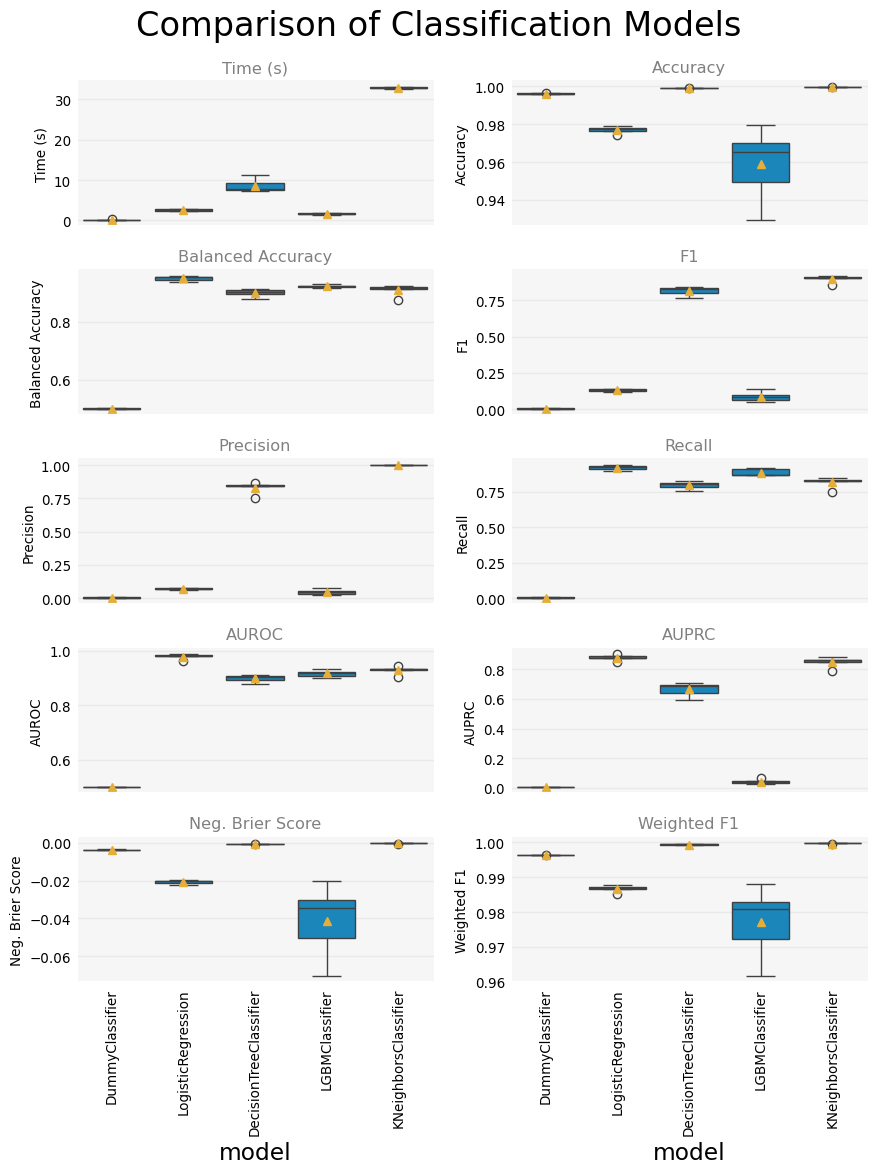

In [14]:
plot_model_performance_metrics(df_results, title="Comparison of Classification Models")

We can see that the logistic regression model has the best performance in terms of the chosen metric and is also one of the fastest models. However, we see that although the recall is high, the precision is extremely low. This means that the model is classifying most of the samples as positive, which is not good. We need to find a balance between precision and recall.

So we will use the second-best model concerning average precision, the KNN model. It has a good balance between precision and recall. However, it is one of the slowest models. And here it is not an issue related to fine-tuning and hyperparameters. We have a considerable dataset, and KNN essentially calculates the distance between each sample and all the other samples. This is a very time-consuming process during the scoring phase (you can compare fit and score times in the results dataframe).

To deal with the time issue, we will explore sampling techniques in the next notebook.

For now, let's identify which features are most important for the KNN model. KNN does not have a feature importance attribute like tree-based models. However, we can use the permutation importance technique to identify the most important features for the KNN model.

In [15]:
clf = build_classification_model_pipeline(
    **classifiers["KNeighborsClassifier"]
)
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('power_transform',
                                                  PowerTransformer(),
                                                  ['Time', 'Amount']),
                                                 ('robust_scaler',
                                                  StandardScaler(),
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V14',
                                                   'V16', 'V17', 'V18', 'V19',
                                                   'V20', 'V21', 'V23', 'V24',
                                                   'V25', 'V26', 'V27',
                                                   'V28'])])),
                ('clf', KNeighborsClassifier(n_jobs=-1))])

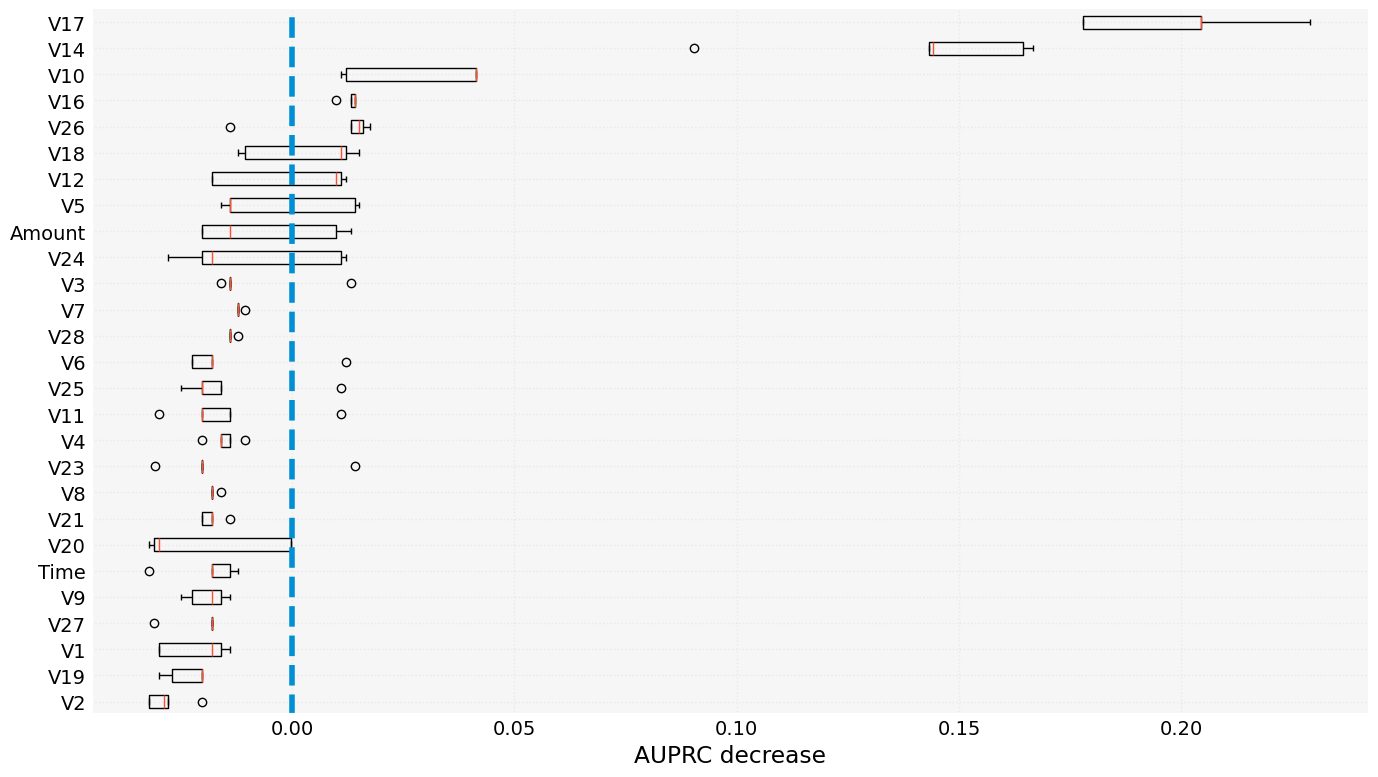

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

clf.fit(X_train, y_train)

perm_imp = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="average_precision",
    max_samples=0.2,
)

fig, ax = plt.subplots()

order = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[order].T, vert=False, tick_labels=X.columns[order])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("AUPRC decrease")
ax.grid(True, linestyle=":")

plt.show()

We see that features *V17* and *V14* decrease the average precision the most when they are permuted. This means that these features are the most important for the KNN model. This is consistent with the results of the graphical and statistical feature importance analysis we did in the previous notebook.